#ECSE 415 Assignment 4
Hanwen Wang 260778557

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# make path = './' connect to the path of the folder stroing images
path = '/content/drive/My Drive/ECSE_415_F_2020/Assignment_4/'

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

# 1. Image Segmentation using K-means

In [ ]:
# K is the number of clusters, when K increases, more colors will appear
np.random.seed(10)
# calculate euclidean distance between the centeroid and each data point in points
def euclidean_distance(centroid, points):
  return np.linalg.norm(points-centroid,axis=1)

# initialize clusters as k randomly selected points from points
def init_centers(points,k):
  return points[np.random.randint(points.shape[0], size=k)]

def Kmeans(points,k):
  # randomly initialize the cluster centers
  centroids = init_centers(points,k)
  # indices of closest centroid will be stored here
  labels = np.zeros(points.shape[0], dtype=np.float32)
  # euclidean distance calculated for each point will be stored here
  distances = np.zeros([points.shape[0], k], dtype=np.float32)
  for h in range(10): # loop 10 times
    # counter is the index of centroids and center is the value of centroids
    for counter,center in enumerate(centroids): 
      distances[:,counter] = euclidean_distance(center,points)
    
    labels = np.argmin(distances,axis=1)  # gives the indices of minimum values
    # update centroid location
    for j in range(k):
      centroids[j] = np.mean(points[labels==j],0)
  return labels, centroids

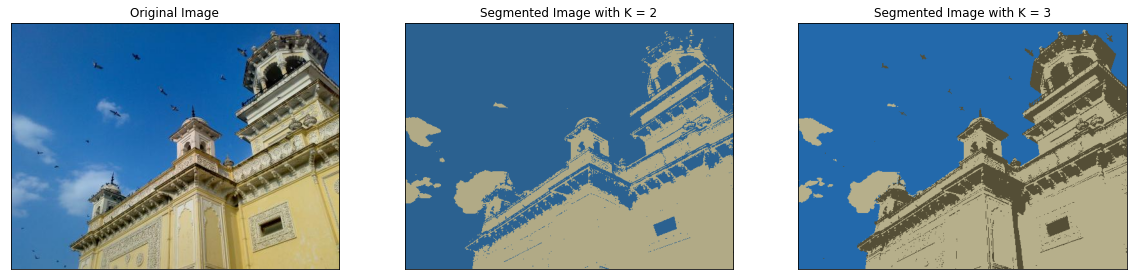

In [ ]:
img_home = cv2.cvtColor(cv2.imread(path+'home.jpg'), cv2.COLOR_BGR2RGB)
home_Z = img_home.reshape((-1,3))

# convert to np.float32
home_Z = np.float32(home_Z)

# When K = 2
K = 2
home_labels_2, home_centroid_2 = Kmeans(home_Z,K)

# Now convert back into uint8, and make original image
home_centroid_2 = np.uint8(home_centroid_2)
home_out_2 = home_centroid_2[home_labels_2.flatten()]
home_out_2 = home_out_2.reshape((img_home.shape))

# When K = 3
K = 3
home_labels_3, home_centroid_3 = Kmeans(home_Z,K)

# Now convert back into uint8, and make original image
home_centroid_3 = np.uint8(home_centroid_3)
home_out_3 = home_centroid_3[home_labels_3.flatten()]
home_out_3 = home_out_3.reshape((img_home.shape))

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img_home)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(home_out_2)
plt.title("Segmented Image with K = 2"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(home_out_3)
plt.title("Segmented Image with K = 3"), plt.xticks([]), plt.yticks([])
plt.show()

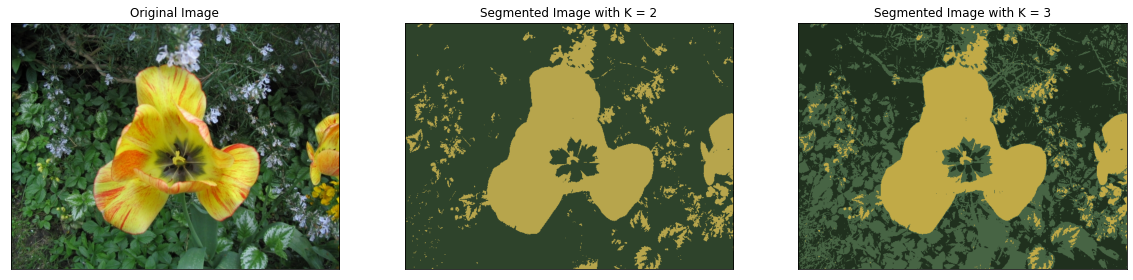

In [ ]:
img_flower = cv2.cvtColor(cv2.imread(path+'flower.jpg'), cv2.COLOR_BGR2RGB)
flower_Z = img_flower.reshape((-1,3))

# convert to np.float32
flower_Z = np.float32(flower_Z)

# When K = 2
K = 2
flower_labels_2, flower_centroid_2 = Kmeans(flower_Z,K)

# Now convert back into uint8, and make original image
flower_centroid_2 = np.uint8(flower_centroid_2)
flower_out_2 = flower_centroid_2[flower_labels_2.flatten()]
flower_out_2 = flower_out_2.reshape((img_flower.shape))

# When K = 3
K = 3
flower_labels_3, flower_centroid_3 = Kmeans(flower_Z,K)

# Now convert back into uint8, and make original image
flower_centroid_3 = np.uint8(flower_centroid_3)
flower_out_3 = flower_centroid_3[flower_labels_3.flatten()]
flower_out_3 = flower_out_3.reshape((img_flower.shape))

plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(img_flower)
plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132)
plt.imshow(flower_out_2)
plt.title("Segmented Image with K = 2"), plt.xticks([]), plt.yticks([])
plt.subplot(133)
plt.imshow(flower_out_3)
plt.title("Segmented Image with K = 3"), plt.xticks([]), plt.yticks([])
plt.show()

# 2. Disparity

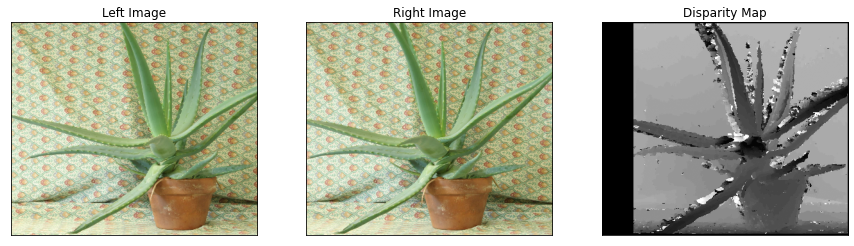

In [3]:
# When value of disparity is larger, means that the object is
# more far away from two viewpoints
# load left and right images
imgL = cv2.imread(path+"aloeL.jpg");
imgR = cv2.imread(path+"aloeR.jpg");

# resize images for fast processing
imgL = cv2.resize(imgL, None, fx=0.3, fy=0.3)
imgR = cv2.resize(imgR, None, fx=0.3, fy=0.3)

# convert to grayscale
imgL_gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR_gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

# 1. Extract a 5 × 5 window centered at each pixel-location (i, j)
# in the left image. Let’s call these windows reference windows.
def reference_windows(img,i,j):
  # this means from i-2 to i+3 (i+3 not included)
  # and from j-2 to j+3 (j+3 not included)
  # so this is a 5x5 patch centered at (i,j)
  patch = img[i-2:i+3,j-2:j+3]
  return patch

# 2. (c) Compute sum-of-square-difference(SSD) between the windows in the
# search region and the reference window
def SSD(patch,window):
  ssd = 0
  for x in range(5):
    for y in range(5):
      diff = float(window[x][y]) - float(patch[x][y])
      ssd += (int)(diff * diff)
  return ssd

# 2. For each reference window in the left image do the following
height = imgL_gray.shape[0]
width = imgL_gray.shape[1]
D = np.zeros((height,width))

# for each reference window in the left image
for i in range(height):
  for j in range(width):
    # 2. (b) Set disparity to 48 for few boarder pixel-locations 
    # lie outside the boundary of the image
    if (i-2 < 0) or (i+2 > height-1) or (j-49 < 0) or (j+2 > width-1):
        D[i][j] = 48
    else:
      # 2. (a) create a search region on the right scanline
      patch = reference_windows(imgL_gray,i,j)
      search_region = imgR_gray[i-2:i+3,j-49:j+3]
      minimum = 100000
      for b in range(48):
        search_window = search_region[0:5,b:b+5]
        ssd = SSD(patch,search_window)
        # 2. (d) if ssd is smaller than minimum, update the minimum value
        # and value stored in D[i][j]
        if ssd < minimum:
          minimum = ssd
          D[i][j] = j - (j-47+b)

# 3. display images and set cmap in plt.imshow of Dto gray_r
plt.figure(figsize=(15,15))
plt.subplot(131), plt.imshow(cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB))
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB))
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(D, cmap="gray_r")
plt.title("Disparity Map"), plt.xticks([]), plt.yticks([])
plt.show()

# 3. Optical Flow

winsize =  [ 5  7  9 11 13 15 17 19 21]
MSE =  [1.09771726 0.81693522 0.70389798 0.63740485 0.5983505  0.57417605
 0.55661251 0.54147434 0.52820969]


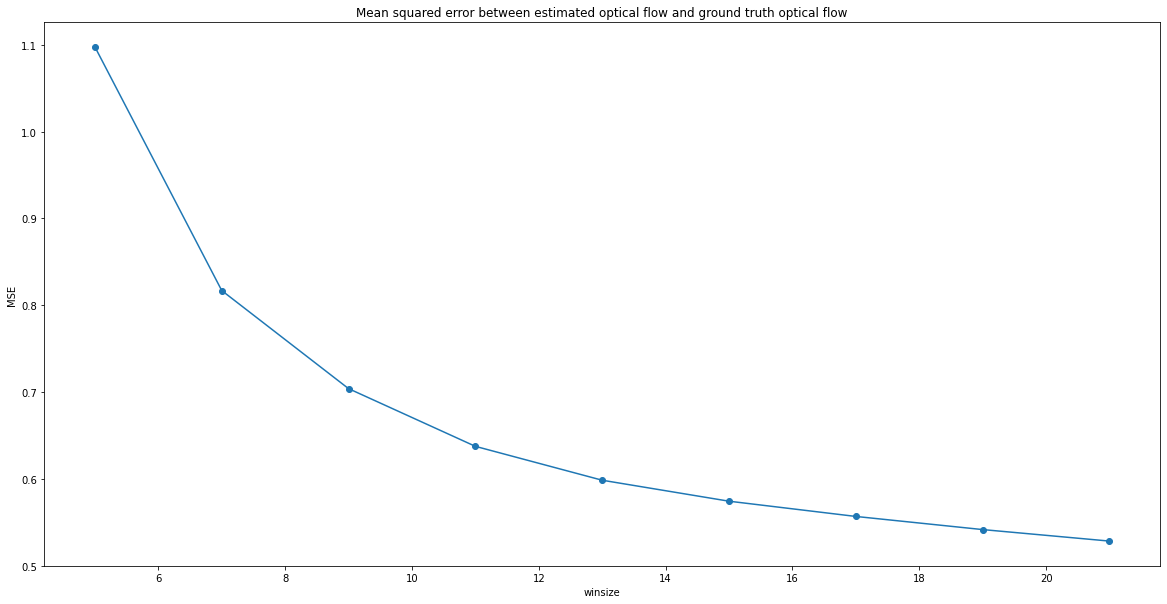

In [ ]:
# read images
frame_img1 = cv2.imread(path + "frame10.png")
frame_img2 = cv2.imread(path + "frame11.png")

# convert to grayscale
frame_img1_gray = cv2.cvtColor(frame_img1, cv2.COLOR_BGR2GRAY)
frame_img2_gray = cv2.cvtColor(frame_img2, cv2.COLOR_BGR2GRAY)

# load ground truth flow
gt = np.load(path + 'flow10.npz')['flow']

# 1. Use calcOpticalFlowFarneback from OpenCV to compute optical flow
# between the input frames with the arguments set as follows.

# define two arrays used to store window size and calculated MSE values
# winsize_x_axis should store int values while MSE_y_axis should store float numbers
winsize_x_axis = np.zeros(9,dtype=int)
MSE_y_axis = np.zeros(9)

# winsize vary from 5 to 21 in steps of 2, so there are 9 steps in total
for n in range(9):
  # store current window size
  winsize_x_axis[n]=5+2*n
  flow = cv2.calcOpticalFlowFarneback(prev=frame_img1_gray, 
                                      next=frame_img2_gray,
                                      flow=None,
                                      pyr_scale=0.5,
                                      levels=3,
                                      winsize=winsize_x_axis[n],
                                      iterations=3,
                                      poly_n=5,
                                      poly_sigma=1.2,
                                      flags=0)
  # calculate Mean Squared Error and store the value
  MSE_y_axis[n] = np.square(np.subtract(flow,gt)).mean()

print('winsize = ', winsize_x_axis)
print('MSE = ', MSE_y_axis)

# 2. Plot MSE (yaxis) vs winsize (x-axis). 
plt.figure(figsize = (20, 10))
plt.plot(winsize_x_axis,MSE_y_axis,marker='o')
plt.title('Mean squared error between estimated optical flow and ground truth optical flow')
plt.xlabel('winsize')
plt.ylabel('MSE')
plt.show()

MSE value decreases with increasing of winsize, as a result, we can conclude that the error decreases with increasing window-size. However, we can see that the decreasing gradient is becoming shallower. So the error change might become stationary up to some point. Larger window size values increase the algorithm robustness to image noise and give more chances for fast motion detection, but yield more blurred motion field. So when increasing in window size value, more things are detected, that is why the error is smaller. However, things have a more blurred effect as well, that is the reason why the error decreasing amount is reduced.